# **Text Emojifier**

## Setup

In [359]:
import math

from Tools.scripts.pdeps import inverse
from kagglehub import dataset_download
import os
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sb
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import re
import numpy as np
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

In [236]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [237]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

device='cpu'


### Dataframe

In [238]:
def get_emojis_df():
    path = dataset_download("hariharasudhanas/twitter-emoji-prediction")

    dataframes = {}
    for dirpath, dirnames, filenames in os.walk(path):
        if "Train.csv" in filenames:
            csv_path = os.path.join(dirpath, "Train.csv")
            dataframes["Dataset"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)
        if "Mapping.csv" in filenames:
            csv_path = os.path.join(dirpath, "Mapping.csv")
            dataframes["Mapping"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)

    if len(dataframes) != 2:
        raise FileNotFoundError("Some files were not found in the specified directories.")

    return dataframes

In [239]:
def mapping_to_dict(mapping):
    emoticons = mapping['emoticons'].tolist()
    mapp = {}
    for emo in range(0, len(emoticons)):
        mapp[emo]= emoticons[emo]
    return mapp

In [240]:
def load_or_compute_df(file_path, function, *args):
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        return joblib.load(file_path)

    print(f"Computing and saving {file_path}...")
    df = function(*args)
    joblib.dump(df, file_path)
    return df

In [241]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove extra white space from text
    # text = re.sub(r'\W', ' ', str(text))          # Remove all the special characters from text
    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)   # Remove all single characters from text
    # text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove any character that isn't alphabetical
    text = text.lower()

    return text

In [242]:
def delete_emoji(df, emoji_number, mapping):
    df.drop(df[df['Label'] == emoji_number].index, inplace=True)
    mapping[emoji_number] = mapping[len(mapping)-1]
    df['Label'] = df['Label'].apply(lambda x: emoji_number if x == len(mapping)-1 else x)
    del mapping[len(mapping)-1]
    return df, mapping

In [243]:
def unify_emojis(df, emojis_numbers, mapping):
    new_label = emojis_numbers[0]
    for emoji_number in emojis_numbers[1:]:
        df['Label'] = df['Label'].apply(lambda x: new_label if x == emoji_number else x)
        del mapping[emoji_number]
    return df, mapping

In [244]:
def fix_missing(df, mapping):
    keys_sorted = [key for key in mapping.keys()]
    print(keys_sorted, type(keys_sorted))
    for i in range(0, len(mapping)):
        if i not in mapping:
            prev_key = keys_sorted.pop()
            df['Label'] = df['Label'].apply(lambda x: i if x == prev_key else x)
            mapping[i] = mapping[prev_key]
            del mapping[prev_key]
    return df, mapping

In [245]:
def encode_df(df):
    df.dropna(inplace=True)

    df['TEXT processed'] = df['TEXT'].apply(process_text)
    df['TEXT tokenized'] = df['TEXT processed'].apply(lambda x: word_tokenize(x))
    df['TEXT stemmed'] = df['TEXT tokenized'].apply(lambda tokens: [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words])
    return df

In [246]:
def get_encoded_dfs():
    dfs = get_emojis_df()

    df = dfs['Dataset']
    mapping = mapping_to_dict(dfs['Mapping'])
    for emoji_num in [19, 12, 11, 9, 8, 5]:  # '❤', '💯', '☀', '🎄', '😘', '🇺🇸'
        df, mapping = delete_emoji(df, emoji_num, mapping)
    df, mapping = unify_emojis(df, [1, 6], mapping)  # '📷', '📸'
    df, mapping = unify_emojis(df, [8, 5, 12], mapping)  # '💙', '💕', '💜'
    df, mapping = unify_emojis(df, [10, 0, 4, 11], mapping)  # '😁', '😜', '😉', '😊'
    df, mapping = unify_emojis(df, [7, 9], mapping)  # '🔥', '😎'

    df, mapping = fix_missing(df, mapping)

    df = encode_df(df)

    return df, mapping

In [247]:
df, emoji_mapping = get_encoded_dfs()
# inverse_emoji_mapping = {v: k for k, v in emoji_mapping.items()}

[1, 2, 3, 7, 8, 10, 13] <class 'list'>


### Train, validation, test splitting

In [248]:
def get_split_df(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=0):
    assert (train_ratio + test_ratio + val_ratio) == 1

    train_df = df.sample(frac=train_ratio, random_state=random_state)
    remaining_df = df.drop(train_df.index)

    validation_df = remaining_df.sample(frac=val_ratio / (val_ratio + test_ratio), random_state=random_state)
    test_df = remaining_df.drop(validation_df.index)

    return train_df, validation_df, test_df

In [249]:
train_df, val_df, test_df = get_split_df(df)

### Bag of Words

In [250]:
def get_most_popular_words(df, column, num_words=500):
    print(f"Creating dictionary for {column}...")
    dictionary = {}

    for tokens in df[column]:
        for word in tokens:
                dictionary[word] = dictionary.get(word, 0) + 1

    # Sort and get the top words
    sorted_words = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)
    return [word for word, _ in sorted_words[:num_words]]

In [251]:
top_words = get_most_popular_words(train_df, 'TEXT stemmed')
print(top_words[:15])

Creating dictionary for TEXT stemmed...
['user', 'love', 'new', 'amp', 'day', 'happi', 'thank', 'get', 'time', 'night', 'one', 'today', 'got', 'like', 'york']


In [252]:
def add_bag_of_words(df, column, bag_of_word):
    new_df = df.copy()

    for word in bag_of_word:
        new_df[f'word: {word}'] = new_df[f'{column}'].apply(lambda x: int(x.count(word)))
        new_df[f'word: {word}'] = new_df[f'word: {word}'].astype('float32')
        new_df = new_df.copy()

    return new_df

In [253]:
train_df = load_or_compute_df("train_encoded.joblib", add_bag_of_words, train_df, 'TEXT stemmed', top_words)
val_df = load_or_compute_df("val_encoded.joblib", add_bag_of_words, val_df, 'TEXT stemmed', top_words)
test_df = load_or_compute_df("test_encoded.joblib", add_bag_of_words, test_df, 'TEXT stemmed', top_words)

Computing and saving train_encoded.joblib...
Computing and saving val_encoded.joblib...
Computing and saving test_encoded.joblib...


In [254]:
BOW_FEATURES = [f'word: {word}' for word in top_words]
TARGET = 'Label'

### Model Evaluation

In [255]:
def print_metrics(model_name, y_true, y_pred):
    print(f'/////// {model_name} Evaluation ///////')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f} (weighted)')
    print(f'Recall: {recall:.4f} (weighted)')
    print(f'F1 Score: {f1:.4f} (weighted)')

In [256]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [257]:
def print_model_evaluation(model_name, y_true, y_pred):

    print_metrics(model_name, y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred, emoji_mapping)

    print('\n/////// Detailed Classification Report ///////')
    print(classification_report(baseline_y_test, baseline_y_pred, digits=4))

### Saving Models

In [258]:
TRAINED_MODELS_FOLDER = 'trained_models'

In [259]:
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

In [260]:
def save_model(model, model_name):
    model_save_path = os.path.join(TRAINED_MODELS_FOLDER, model_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

## Data Analysis

In [261]:
print('Number of training examples: ', len(train_df))
print('Number of test examples: ', len(test_df))

Number of training examples:  31396
Number of test examples:  6728


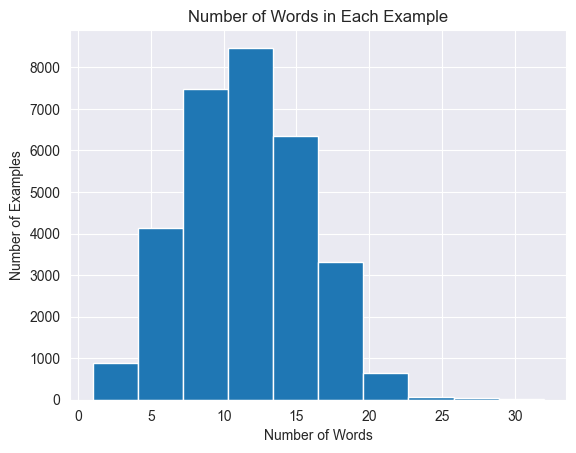

In [262]:
# Histogram of number of words in each example
train_df['TEXT processed'].apply(lambda x: len(x.split())).hist()
plt.xlabel('Number of Words')
plt.ylabel('Number of Examples')
plt.title('Number of Words in Each Example')
plt.show()

In [263]:
# Total number of words in the dataset
total_words = train_df['TEXT tokenized'].apply(lambda x: len(x)).sum()
print('Total number of words in the dataset: ', total_words)

Total number of words in the dataset:  461749


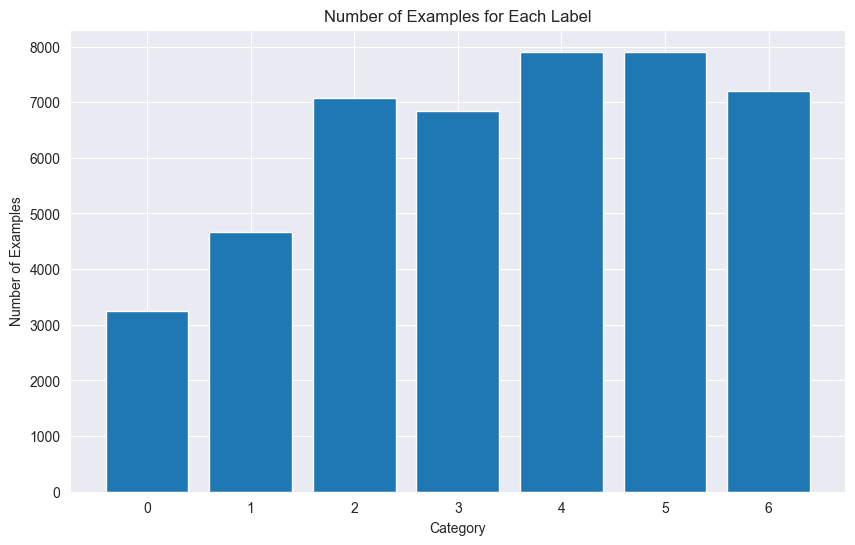

In [264]:
category_counts = df['Label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)

plt.xlabel('Category')
plt.ylabel('Number of Examples')
plt.title('Number of Examples for Each Label')

plt.xticks(ticks=category_counts.index, labels=category_counts.index)
plt.show()

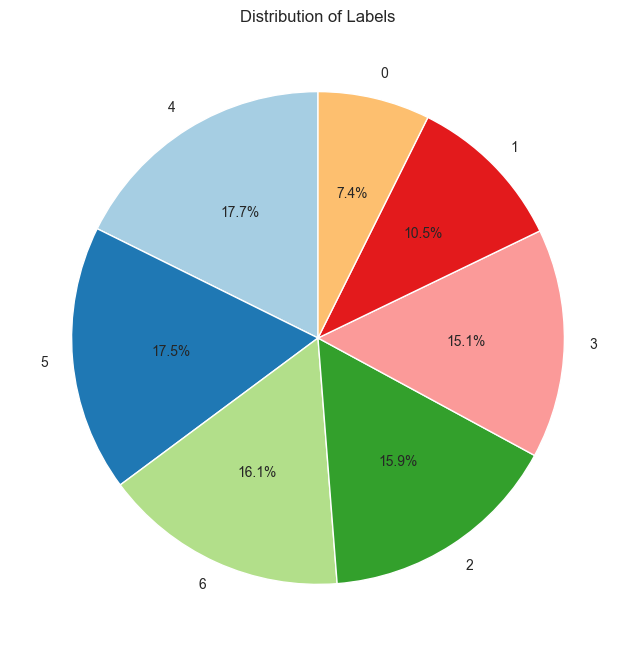

In [265]:
category_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 8))  # Adjust the size of the pie chart
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors  # Optional: Use a colormap for better visuals
)

plt.title('Distribution of Labels')
plt.show()


In [266]:
emoji_mapping

{1: '📸', 2: '😍', 3: '😂', 0: '✨', 4: '😁', 5: '💕', 6: '🔥'}

## Baseline Model

In [267]:
baseline_x_train = pd.concat([train_df[BOW_FEATURES], val_df[BOW_FEATURES]], axis=0)
baseline_y_train = pd.concat([train_df[TARGET], val_df[TARGET]])

baseline_x_test = test_df[BOW_FEATURES]
baseline_y_test = test_df[TARGET]

In [268]:
baseline_model = DummyClassifier(strategy='uniform')

In [269]:
print('Training baseline model...')
baseline_model.fit(baseline_x_train, baseline_y_train)

Training baseline model...


DummyClassifier(strategy='uniform')

In [270]:
print('Predicting with baseline model...')
baseline_y_pred = baseline_model.predict(baseline_x_test)

Predicting with baseline model...


/////// Baseline Model Evaluation ///////
Accuracy: 0.1390
Precision: 0.1498 (weighted)
Recall: 0.1390 (weighted)
F1 Score: 0.1424 (weighted)


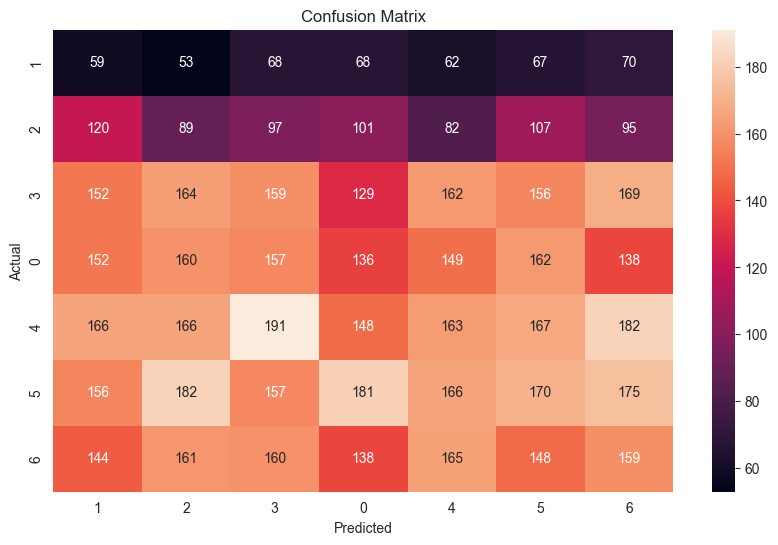


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0622    0.1320    0.0845       447
           1     0.0913    0.1288    0.1068       691
           2     0.1608    0.1457    0.1529      1091
           3     0.1509    0.1290    0.1391      1054
           4     0.1718    0.1378    0.1529      1183
           5     0.1740    0.1432    0.1571      1187
           6     0.1609    0.1479    0.1541      1075

    accuracy                         0.1390      6728
   macro avg     0.1388    0.1378    0.1354      6728
weighted avg     0.1498    0.1390    0.1424      6728



In [271]:
print_model_evaluation('Baseline Model', baseline_y_test, baseline_y_pred)

## Softmax Model

In [384]:
softmax_x_train = torch.tensor(train_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_train = torch.tensor(train_df[TARGET].values, dtype=torch.float32)

softmax_x_val = torch.tensor(val_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_val = torch.tensor(val_df[TARGET].values, dtype=torch.float32)

softmax_x_test = torch.tensor(test_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_test = torch.tensor(test_df[TARGET].values, dtype=torch.float32)

In [385]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x) # Softmax is included in the loss function

In [386]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = softmax_x_train.shape[1]
softmax_model = SoftmaxModel(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(softmax_model.parameters(), lr=0.01)

In [387]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [388]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    softmax_model.train()

    # Forward pass
    outputs = softmax_model(softmax_x_train)
    loss = criterion(outputs, softmax_y_train.long())  # Ensure labels are integers

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    softmax_model.eval()
    with torch.no_grad():
        val_outputs = softmax_model(softmax_x_val)
        val_loss = criterion(val_outputs, softmax_y_val.long())

    val_losses.append(val_loss.item())

    # Check for early stopping
    if val_loss.item() < best_val_loss - min_delta:
        best_val_loss = val_loss.item()
        early_stop_counter = 0
        torch.save(softmax_model.state_dict(), 'best_softmax_model.pth')
    else:
        early_stop_counter += 1

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
softmax_model.load_state_dict(torch.load('best_softmax_model.pth'))
os.remove('best_softmax_model.pth')

Epoch [50/200], Train Loss: 1.7393, Val Loss: 1.7578
Epoch [100/200], Train Loss: 1.7134, Val Loss: 1.7398
Epoch [150/200], Train Loss: 1.7074, Val Loss: 1.7369
Early stopping triggered at epoch 188. Best validation loss: 1.7365


C:\Users\adipe\AppData\Local\Temp\ipykernel_17592\1126631788.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  softmax_model.load_state_dict(torch.load('best_softmax_mode

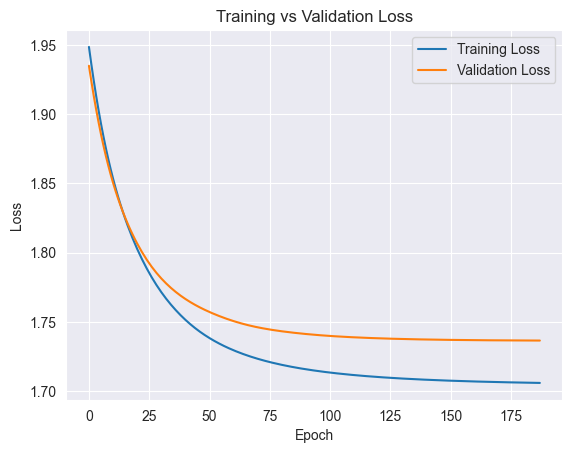

In [389]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// Softmax Model Evaluation ///////
Accuracy: 0.3133
Precision: 0.3137 (weighted)
Recall: 0.3133 (weighted)
F1 Score: 0.3043 (weighted)


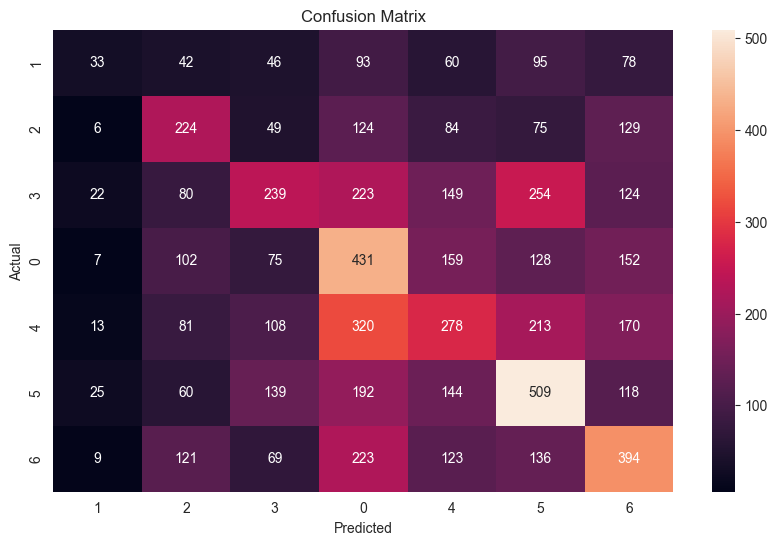


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0622    0.1320    0.0845       447
           1     0.0913    0.1288    0.1068       691
           2     0.1608    0.1457    0.1529      1091
           3     0.1509    0.1290    0.1391      1054
           4     0.1718    0.1378    0.1529      1183
           5     0.1740    0.1432    0.1571      1187
           6     0.1609    0.1479    0.1541      1075

    accuracy                         0.1390      6728
   macro avg     0.1388    0.1378    0.1354      6728
weighted avg     0.1498    0.1390    0.1424      6728



In [390]:
softmax_model.eval()
with torch.no_grad():
    test_outputs = softmax_model(softmax_x_test)
    softmax_y_pred = torch.argmax(test_outputs, dim=1)
print_model_evaluation('Softmax Model', softmax_y_test, softmax_y_pred)

In [279]:
save_model(softmax_model, 'softmax_model.pth')

Model saved to trained_models\softmax_model.pth


## Basic Neural Network

In [306]:
train_dataset = TensorDataset(torch.tensor(train_df[BOW_FEATURES].values, dtype=torch.float32),
                               torch.tensor(train_df[TARGET].values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_df[BOW_FEATURES].values, dtype=torch.float32),
                             torch.tensor(val_df[TARGET].values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_df[BOW_FEATURES].values, dtype=torch.float32),
                              torch.tensor(test_df[TARGET].values, dtype=torch.float32))

In [307]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [324]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, output_size)  # No activation, raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        return self.network(x)

In [325]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = train_df[BOW_FEATURES].shape[1]
simple_nn_model = SimpleNN(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_nn_model.parameters(), lr=0.001, weight_decay=1e-4)

In [326]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [327]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    simple_nn_model.train()
    running_train_loss = 0.0  # Accumulate training loss
    for inputs, targets in train_loader:
        # Forward pass
        outputs = simple_nn_model(inputs)
        loss = criterion(outputs, targets.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    simple_nn_model.eval()
    running_val_loss = 0.0  # Accumulate validation loss
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = simple_nn_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets.long())
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(simple_nn_model.state_dict(), 'best_simple_nn_model.pth')
    else:
        early_stop_counter += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
simple_nn_model.load_state_dict(torch.load('best_simple_nn_model.pth'))
os.remove('best_simple_nn_model.pth')

Epoch [1/50], Train Loss: 1.8778, Val Loss: 1.7772
Epoch [2/50], Train Loss: 1.7946, Val Loss: 1.7441
Epoch [3/50], Train Loss: 1.7628, Val Loss: 1.7302
Epoch [4/50], Train Loss: 1.7456, Val Loss: 1.7200
Epoch [5/50], Train Loss: 1.7338, Val Loss: 1.7115
Epoch [6/50], Train Loss: 1.7236, Val Loss: 1.7127
Epoch [7/50], Train Loss: 1.7146, Val Loss: 1.7080
Epoch [8/50], Train Loss: 1.7116, Val Loss: 1.7073
Epoch [9/50], Train Loss: 1.7029, Val Loss: 1.7032
Epoch [10/50], Train Loss: 1.6973, Val Loss: 1.6987
Epoch [11/50], Train Loss: 1.6943, Val Loss: 1.7001
Epoch [12/50], Train Loss: 1.6897, Val Loss: 1.6976
Epoch [13/50], Train Loss: 1.6857, Val Loss: 1.6970
Epoch [14/50], Train Loss: 1.6817, Val Loss: 1.6979
Epoch [15/50], Train Loss: 1.6757, Val Loss: 1.6981
Epoch [16/50], Train Loss: 1.6762, Val Loss: 1.6997
Epoch [17/50], Train Loss: 1.6737, Val Loss: 1.7004
Epoch [18/50], Train Loss: 1.6703, Val Loss: 1.7001
Epoch [19/50], Train Loss: 1.6629, Val Loss: 1.6960
Epoch [20/50], Train 

C:\Users\adipe\AppData\Local\Temp\ipykernel_17592\863355795.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_nn_model.load_state_dict(torch.load('best_simple_nn_m

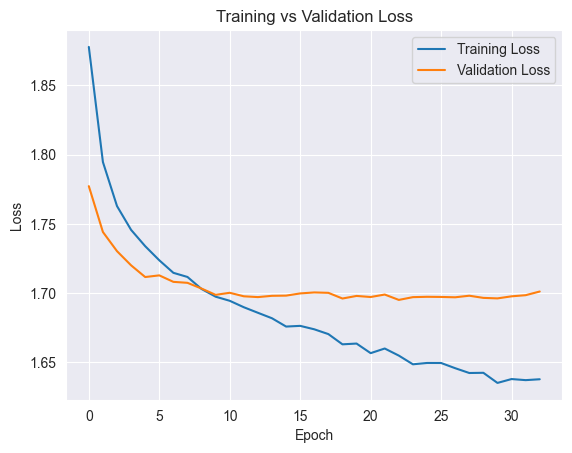

In [328]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// SimpleNN Model Evaluation ///////
Accuracy: 0.3338
Precision: 0.3329 (weighted)
Recall: 0.3338 (weighted)
F1 Score: 0.3176 (weighted)


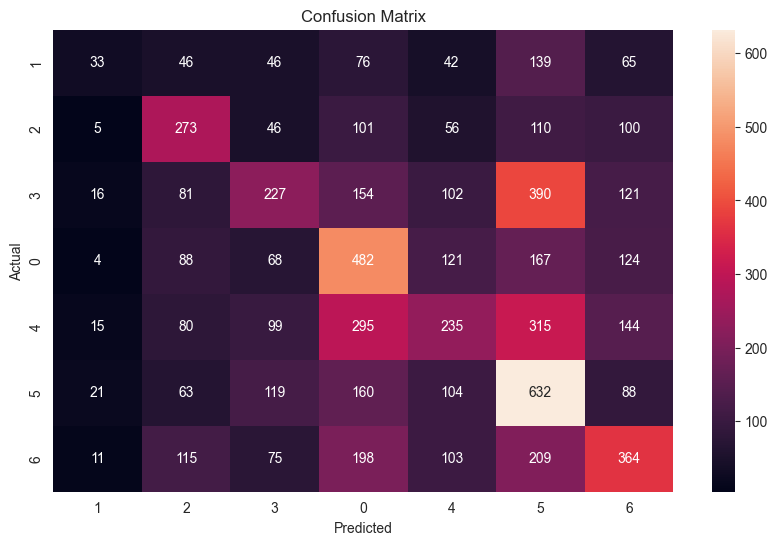


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0622    0.1320    0.0845       447
           1     0.0913    0.1288    0.1068       691
           2     0.1608    0.1457    0.1529      1091
           3     0.1509    0.1290    0.1391      1054
           4     0.1718    0.1378    0.1529      1183
           5     0.1740    0.1432    0.1571      1187
           6     0.1609    0.1479    0.1541      1075

    accuracy                         0.1390      6728
   macro avg     0.1388    0.1378    0.1354      6728
weighted avg     0.1498    0.1390    0.1424      6728



In [332]:
simple_nn_model.eval()
all_preds = []

with torch.no_grad():
    for test_inputs, _ in test_loader:  # Use test_loader for batch processing
        test_outputs = simple_nn_model(test_inputs)
        batch_preds = torch.argmax(test_outputs, dim=1)
        all_preds.append(batch_preds)
simple_nn_y_pred = torch.cat(all_preds)

print_model_evaluation('SimpleNN Model', test_df[TARGET].values, simple_nn_y_pred.cpu().numpy())

In [333]:
save_model(simple_nn_model, 'simple_nn_model.pth')

Model saved to trained_models\simple_nn_model.pth


## LSTM with Embeddings

### Word Embeddings

In [334]:
f = open("glove.6B/glove.6B.50d.txt", encoding='utf8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype='float')
    embedding_index[word] = emb

In [335]:
embedding_index['user']

array([ 0.65028  , -0.1691   ,  1.1237   ,  0.67691  ,  0.55291  ,
       -0.2456   , -0.36449  , -0.94084  ,  0.91122  ,  0.62275  ,
        0.50429  ,  0.69679  ,  0.5796   , -0.16755  ,  0.38266  ,
       -0.20152  , -1.0036   ,  0.039738 ,  1.0055   , -0.92738  ,
       -0.0062525, -0.4887   , -0.32331  ,  1.211    ,  0.85893  ,
       -0.63384  ,  0.45837  , -0.55207  ,  0.26687  , -0.36631  ,
        2.9222   , -0.37146  , -0.30435  , -0.99872  ,  0.014728 ,
        0.53908  ,  0.20362  ,  0.077918 , -0.64787  , -0.65404  ,
        1.4543   , -0.13311  , -0.56069  ,  1.1655   , -0.50198  ,
       -0.4995   ,  1.1567   ,  0.20633  ,  0.89666  ,  0.3005   ])

In [336]:
def get_embedding_output(X_tokenized, max_sequence_len=20, padding_value=0.0):
    """
    Convert tokenized text data into embedding vectors with padding.

    Args:
    X_tokenized (list of lists): Tokenized text, where each sample is a list of tokens.
    max_sequence_len (int): Maximum number of tokens per sequence.
    padding_value (float): Value to use for padding shorter sequences.

    Returns:
    np.ndarray: Array of shape (num_samples, max_sequence_len, embedding_dim=50).
    """
    embedding_dim = 50
    embedding_output = np.full((len(X_tokenized), max_sequence_len, embedding_dim), padding_value, dtype=np.float32)

    for ix, tokens in enumerate(X_tokenized):
        for ij, token in enumerate(tokens[:max_sequence_len]):
            embedding_vector = embedding_index.get(token.lower())
            if embedding_vector is not None:
                embedding_output[ix][ij] = embedding_vector

    return embedding_output

In [337]:
x_embed = get_embedding_output(df['TEXT tokenized'])
y_one_hot = keras.utils.to_categorical(df[TARGET])

In [338]:
print(f"{x_embed.shape=}, {y_one_hot.shape=}")

x_embed.shape=(44852, 20, 50), y_one_hot.shape=(44852, 7)


In [339]:
from sklearn.model_selection import train_test_split # TODO switch withh our function
x_train, x_test, y_train, y_test = train_test_split(x_embed, y_one_hot, test_size = 0.2)

### Model

In [345]:
model = Sequential()
model.add(Bidirectional(LSTM(units = 512, return_sequences=True), input_shape = (20,50)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

C:\Users\adipe\PycharmProjects\Emojifier\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 20, 1024)       │     2,306,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,005,767 (19.10 MB)

 Trainable params: 5,005,767 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [346]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [347]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=64, epochs=10,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 176s 382ms/step - accuracy: 0.2287 - loss: 1.8535 - val_accuracy: 0.3364 - val_loss: 1.6842
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 159s 353ms/step - accuracy: 0.3376 - loss: 1.6790 - val_accuracy: 0.3507 - val_loss: 1.6381
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 162s 361ms/step - accuracy: 0.3748 - loss: 1.6125 - val_accuracy: 0.3655 - val_loss: 1.6118
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 384ms/step - accuracy: 0.3929 - loss: 1.5600 - val_accuracy: 0.3911 - val_loss: 1.5626
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 184s 409ms/step - accuracy: 0.4210 - loss: 1.4961 - val_accuracy: 0.3982 - val_loss: 1.5624
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 169s 378ms/step - accuracy: 0.4527 - loss: 1.4329 - val_accuracy: 0.4091 - val_loss: 1.5373
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 187s 417ms/step - accuracy: 0.4823 - loss: 1.3589 - val_accuracy: 0.4103 - val_loss: 1.5631
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 201s 448ms/step - accuracy: 0.5285 -

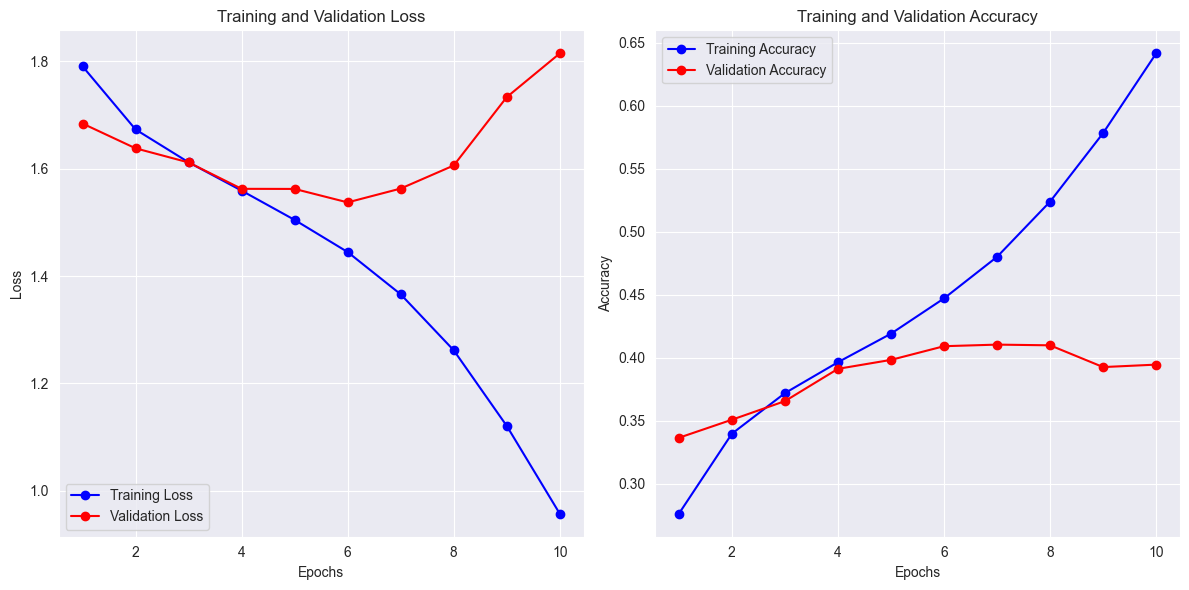

In [352]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [348]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.3972 - loss: 1.5842


[1.581645131111145, 0.3918180763721466]

281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step
/////// Bidirectional LSTM Model Evaluation ///////
Accuracy: 0.3918
Precision: 0.3938 (weighted)
Recall: 0.3918 (weighted)
F1 Score: 0.3858 (weighted)


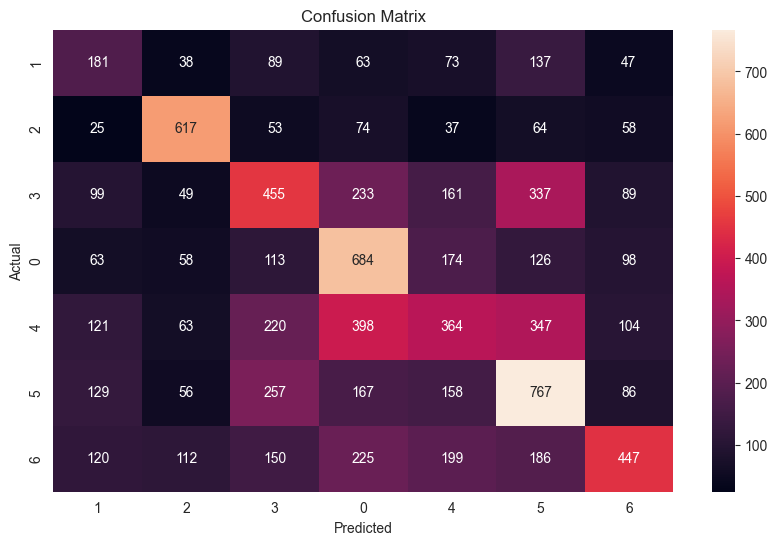


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0622    0.1320    0.0845       447
           1     0.0913    0.1288    0.1068       691
           2     0.1608    0.1457    0.1529      1091
           3     0.1509    0.1290    0.1391      1054
           4     0.1718    0.1378    0.1529      1183
           5     0.1740    0.1432    0.1571      1187
           6     0.1609    0.1479    0.1541      1075

    accuracy                         0.1390      6728
   macro avg     0.1388    0.1378    0.1354      6728
weighted avg     0.1498    0.1390    0.1424      6728



In [349]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Model', y_true, y_pred)


In [351]:
model.save('lstm_model.h5')

### Attention

In [377]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Score computation
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Convert scores to probabilities
        alpha = K.softmax(e, axis=1)
        # Context vector as weighted sum of input sequences
        context = K.sum(alpha * x, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [378]:
# Input layer
input_layer = Input(shape=(20, 50))

# Bidirectional LSTM
lstm_layer = Bidirectional(LSTM(units=512, return_sequences=True))(input_layer)
dropout_layer1 = Dropout(0.3)(lstm_layer)

# Attention mechanism
attention_layer = Attention()(dropout_layer1)

# Additional dense layers with dropout
dense1 = Dense(units=128, activation='relu')(attention_layer)
dense2 = Dense(units=64, activation='relu')(dense1)
dense3 = Dense(units=32, activation='relu')(dense2)


# Output layer
output_layer = Dense(units=len(emoji_mapping), activation='softmax')(dense3)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 20, 1024)       │     2,306,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 1024)           │         1,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,448,840 (9.34 MB)

 Trainable params: 2,448,840 (9.34 MB)

 Non-trainable params: 0 (0.00 B)

In [379]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=64, epochs=15,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 96s 207ms/step - accuracy: 0.2512 - loss: 1.8263 - val_accuracy: 0.3474 - val_loss: 1.6634
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.3551 - loss: 1.6511 - val_accuracy: 0.3697 - val_loss: 1.6175
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 178ms/step - accuracy: 0.3835 - loss: 1.5874 - val_accuracy: 0.3867 - val_loss: 1.5708
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 83s 184ms/step - accuracy: 0.4030 - loss: 1.5400 - val_accuracy: 0.3928 - val_loss: 1.5520
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.4206 - loss: 1.4895 - val_accuracy: 0.4062 - val_loss: 1.5393
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.4535 - loss: 1.4216 - val_accuracy: 0.4014 - val_loss: 1.5492
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 80s 178ms/step - accuracy: 0.4752 - loss: 1.3600 - val_accuracy: 0.4165 - val_loss: 1.5412
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 78s 174ms/step - accuracy: 0.5250 - loss: 1

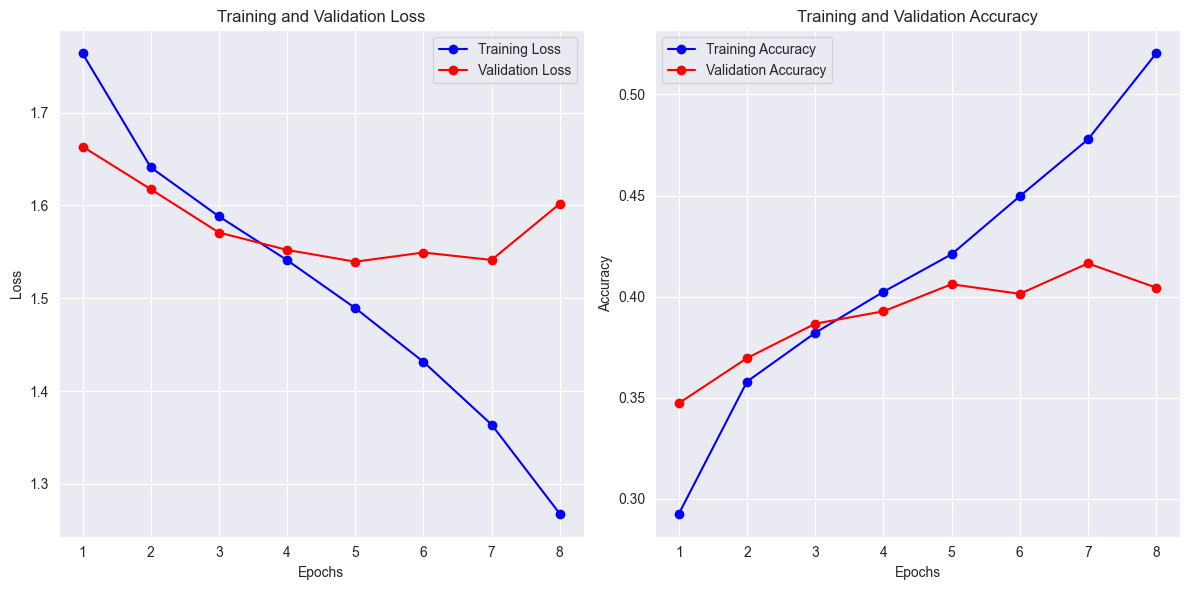

In [380]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [381]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.3986 - loss: 1.5680


[1.5649936199188232, 0.40107011795043945]

281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step
/////// Bidirectional LSTM Model Evaluation ///////
Accuracy: 0.4011
Precision: 0.3999 (weighted)
Recall: 0.4011 (weighted)
F1 Score: 0.3877 (weighted)


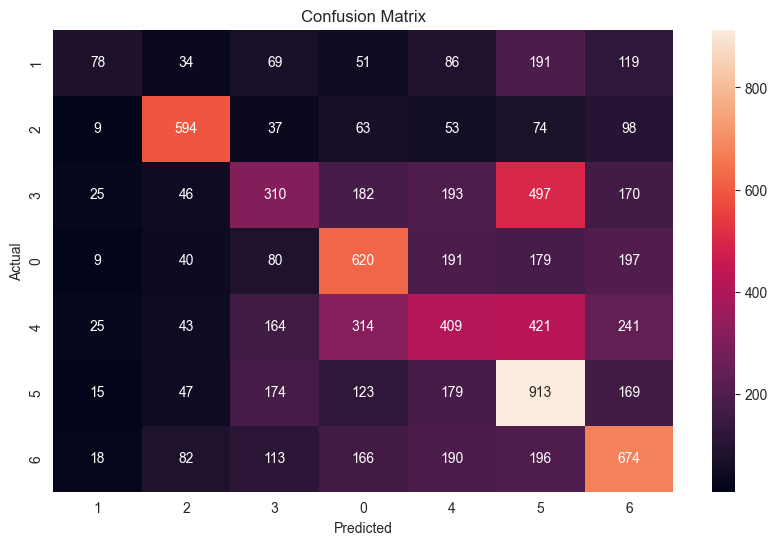


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0622    0.1320    0.0845       447
           1     0.0913    0.1288    0.1068       691
           2     0.1608    0.1457    0.1529      1091
           3     0.1509    0.1290    0.1391      1054
           4     0.1718    0.1378    0.1529      1183
           5     0.1740    0.1432    0.1571      1187
           6     0.1609    0.1479    0.1541      1075

    accuracy                         0.1390      6728
   macro avg     0.1388    0.1378    0.1354      6728
weighted avg     0.1498    0.1390    0.1424      6728



In [382]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Model', y_true, y_pred)

In [383]:
model.save('lstm_model_attention2.h5')

### Oversampling

In [412]:
# Calculate the sum of each column in y_one_hot
class_counts = y_one_hot.sum(axis=0)

# convert it to a dictionary
class_counts = {class_label: count for class_label, count in enumerate(class_counts)}
max_class_size = max(class_counts.values())

In [413]:
# Set the desired sampling strategy for each class
sampling_strategy = {
    class_label: max(int(max_class_size * 0.75), count)
    for class_label, count in class_counts.items()
}

# Apply SMOTE with the updated sampling strategy
oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(x_embed.reshape(-1, 1000), y_one_hot)


In [414]:
print(len(X_resampled), len(y_resampled))

104137 104137


In [415]:
x_resampled = X_resampled.reshape(-1, 20, 50)
x_resampled.shape, y_resampled.shape

((104137, 20, 50), (104137, 19))

In [416]:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(x_resampled, y_resampled, test_size = 0.2)

In [417]:
model = Sequential()
model.add(Bidirectional(LSTM(units=512, return_sequences=True), input_shape=(20, 50)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

C:\Users\adipe\PycharmProjects\Emojifier\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 20, 1024)       │     2,306,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 512)            │     2,623,488 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 19)             │           627 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,006,163 (19.10 MB)

 Trainable params: 5,006,163 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [418]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [419]:
hist = model.fit(x_train_resampled, y_train_resampled, validation_split=0.2, shuffle=True, batch_size=64, epochs=100,
                 callbacks=[EarlyStopping(patience=30, restore_best_weights=True)])

Epoch 1/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 377s 354ms/step - accuracy: 0.1287 - loss: 2.7851 - val_accuracy: 0.2282 - val_loss: 2.4860
Epoch 2/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 367s 352ms/step - accuracy: 0.2550 - loss: 2.3884 - val_accuracy: 0.2806 - val_loss: 2.2990
Epoch 3/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 376s 361ms/step - accuracy: 0.3133 - loss: 2.1970 - val_accuracy: 0.3227 - val_loss: 2.1710
Epoch 4/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 367s 352ms/step - accuracy: 0.3713 - loss: 1.9867 - val_accuracy: 0.3683 - val_loss: 2.0380
Epoch 5/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 368s 353ms/step - accuracy: 0.4585 - loss: 1.7030 - val_accuracy: 0.4273 - val_loss: 1.8850
Epoch 6/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 363s 349ms/step - accuracy: 0.5622 - loss: 1.3797 - val_accuracy: 0.4734 - val_loss: 1.8028
Epoch 7/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 358s 343ms/step - accuracy: 0.6567 - loss: 1.0731 - val_accuracy: 0.5143 - val_loss: 1.7662
Epoch 8/100
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 355s 340ms/s

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test_resampled, y_test_resampled)

In [ ]:
model.save('lstm_model_oversampled.h5')